# Assignment 4: Benchmarking Neural Nets with the XOR Problem

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
In this assignment, you will implement your own neural networks to classify non-linear data from the XOR dataset. For references, you may refer to my [lecture 10](https://docs.google.com/presentation/d/1otQfmMomWctLZKI3hHKAA4lLkbXFtagLaQov8gNh4LI/edit?usp=sharing) and [Colab Notebook 10](https://colab.research.google.com/drive/1x5biI3dP5YvvDEI0wapJcSgQNnATDzNe) if you need additional sample codes to help with your assignment. For deliverables, you must write code in Python/Tensorflow and submit **this** Jupyter Notebook file (.ipynb) to earn a total of 100 pts. Note that you must save your Notebook filename under this format: **yourUvaUserId_assignment_4_ann.ipynb**.



In [485]:
# You might want to use the following packages
import numpy as np
import os
%tensorflow_version 2.x
import tensorflow as tf

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial

---
## 1. THE DATASET AND VISUALIZATION

We will use the non-linear toy data called the XOR dataset. You may use the code snippet below to generate the train/validate/test set. Feel free to change the number of samples, and noise level. To keep the ratio between the sets consistent, please do not change the test_size and random_state parameters.



(720, 2)
(200, 2)
(80, 2)


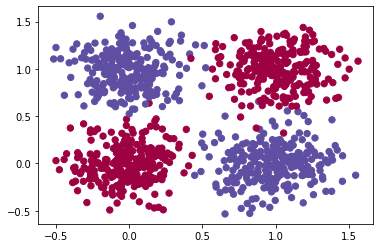

In [486]:
def make_xor(n_points):
    centers = np.array([[0,0],[0,1],[1,0],[1,1]])
    labels = np.array([0,1,1,0])
    data = np.array([]).reshape(-1,3)
    for center, label in zip(centers,labels):
        points = np.random.normal(loc=center,scale=0.2,size=(n_points//4,2))
        points_labels = np.hstack((points,label*np.ones(n_points//4).reshape((-1, 1))))
        data = np.vstack((data,points_labels))
    return (data[:,[0,1]],data[:,2])


X, y = make_xor(1000)
y=y.astype(np.int64)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=49)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size= 0.1, random_state=49) 
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)


---
## 2. TRAIN A SIMPLE ANN FOR CLASSIFICATION TASK (20 pts)

Use the standard libarary of Neural Net on the training data, and then test the classifier on the test data. You will create a simple ANN with 3 layers: an Input Layer, a Hidden Layer and an Output Layer. For each layer, you can specify the number of nodes appropriate for the XOR problem. Also, feel free to tune the network as you see fit. You have to report the accuracy of the network on the validation set.

In [604]:
from tensorflow import keras

my_model = keras.Sequential()
my_model.add(keras.layers.Dense(2, input_dim=2, activation='relu'))
my_model.add(keras.layers.Dense(32, activation='relu'))
my_model.add(keras.layers.Dense(1, activation='sigmoid'))
my_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

my_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100)

my_model.evaluate(x = X_test, y = y_test)
print('The accuracy of the network on the validation set is ', my_model.evaluate(X_val,y_val)[1])

Epoch 1/100
23/23 [==============================] - 0s 5ms/step - loss: 0.2486 - accuracy: 0.5778 - val_loss: 0.2458 - val_accuracy: 0.5375
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2467 - accuracy: 0.5917 - val_loss: 0.2433 - val_accuracy: 0.6000
Epoch 3/100
23/23 [==============================] - 0s 1ms/step - loss: 0.2441 - accuracy: 0.6083 - val_loss: 0.2401 - val_accuracy: 0.6000
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2402 - accuracy: 0.6319 - val_loss: 0.2342 - val_accuracy: 0.6625
Epoch 5/100
23/23 [==============================] - 0s 1ms/step - loss: 0.2342 - accuracy: 0.6972 - val_loss: 0.2263 - val_accuracy: 0.7000
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2260 - accuracy: 0.7667 - val_loss: 0.2158 - val_accuracy: 0.7625
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.2155 - accuracy: 0.8056 - val_loss: 0.2038 - val_accuracy: 0.8000
Epoch 8/100
2

- - -
## 3. IMPLEMENTING YOUR OWN SIMPLE NEURAL NETWORK (60 pts)

Now that you see how the standard library ANN performs on the XOR dataset, you will attempt to implement your own version of the neural network. To help you, a template has been created including the backpropagation. Essensially, you will get the backward gradients for free. However, please note that the backprop implementation assume usage of tanh activation for the hidden layer and softmax for the output layer. There are some subtasks which you need to implement in order to get the network to work properly.

In [593]:
from sklearn.base import BaseEstimator
from scipy.special import softmax
import math
class MyNeuralNet(BaseEstimator):
    """Your implementation of a simple neural network"""

    def __init__ (self, nn_input_dim, nn_hidden_dim, nn_output_dim, alpha):
        """
        Initialize the network with random weights

        @param: nn_input_dim: Number of nodes in the input layer
        @param: nn_hidden_dim: Number of nodes in the hidden layer
        @param: nn_output_dim: Number of nodes in the output layer
        """
        # SUBTASK 1 (10 pts): Initialize the parameters to random values.
        np.random.seed(123)
        self.W1 = np.random.rand(nn_input_dim, nn_hidden_dim) #None
        np.random.seed(243)
        self.b1 = np.random.rand(1,nn_hidden_dim) #None
        np.random.seed(23333)
        self.W2 = np.random.rand(nn_hidden_dim, nn_output_dim) #None
        np.random.seed(23)
        self.b2 = np.random.rand(1, nn_output_dim) #None
        self.alpha = alpha
        
    def loss(self, X, y):

        """
        Evaluate the average loss on the dataset
        """
        # Forward propagation will be needed to calculate the loss
        a1,a2 = self.forward_pass(X)
        # SUBTASK 2 (10 pts): Calculate the loss using log-loss probabilities using a2.
        # You will need to return the average loss on the data 
        data_loss = 0
        for i in range(len(y)):
          if y[i]==0:
            data_loss+=y[i]*math.log(a2[i][0])
          else:
            data_loss+=y[i]*math.log(a2[i][1])        
        return -data_loss
    
    def sM(self,z2):
        for i in range(len(z2)):
          z2[i] = softmax(z2[i])
        return z2

    def Tanh(self, z1):
        for i in range(len(z1)):
          z1[i] = np.tanh(z1[i])
        return z1

    def forward_pass(self, X):
        """
        Pass the signal forward through the layers.
        @param: X: feature
        @return: a1: saved value of the output of the hidden layer
        @return: a2: activated return value of the output layer.
        """
        # SUBTASK 3 (20 pts): Implement Forward propagation.
        # Note that you must implement tanh activiation for the hiden layer, and softmax for the output layer

        z1 = np.matmul(X,self.W1)
        z1 = z1+self.b1
        a1 = self.Tanh(z1) #Piazza says we can use these functions from numpy and scipy
        z2 = np.matmul(a1,self.W2)
        z2 = z2+self.b2
        a2 = self.sM(z2)
        # z1 = self.W1.T.dot(X.T)
        # z1 = z1.T+self.b1
        # a1 = np.tanh(z1.T)
        # a1 = a1.T
        # z2 = np.matmul(self.W2.T,a1.T)
        # z2 = z2.T+self.b2
        # a2 = softmax(z2.T)
        # a2 = a2.T
        # z1 = np.matmul(X,self.W1)
        # z1 = z1+self.b1
        # a1 = np.tanh(z1) #Piazza says we can use these functions from numpy and scipy
        # z2 = np.matmul(a1,self.W2)
        # z2 = z2+self.b2
        # a2 = softmax(z2)
        return a1, a2 

    def backward_pass(self,a1,a2,X,y):
        """
        Pass the signal back and compute the gradient

        @param: X: feature
        @param: y: label
        @param: a1: saved value of the output of the hidden layer
        @param: a2: activated return value of the output layer.

        @return: dW1: the gradient of W1
        @return: db1: the gradient of b1
        @return: dW2: the gradient of W2
        @return: db2: the gradient of b2
        """
        # You do not have to change this function, ...
        # unless you are advanced and want to use different activation function.
        m = len(y) # number of example
        delta2 = a2
        y.astype(np.int64)
        delta2[range(m), y] -= 1
        dW2 = (a1.T).dot(delta2)
        db2 = np.sum(delta2, axis=0, keepdims=True)
        delta1 = delta2.dot(self.W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta1)
        db1 = np.sum(delta1, axis=0)
        return dW1, db1, dW2, db2

    def fit(self, X, y, epochs, X_val, y_val):
        """
        Learns parameters for the neural network and returns the model.
        
        @param: X: the training feature
        @param: y: the train label
        @param: epochs: Number of passes through the training data for gradient descent
        @param: X_val: the feature of validation set
        @param: y_val: the label of validation set
        """

        # Gradient descent. For each batch...
        for i in range(0, epochs):

            # Forward pass
            a1,a2 = self.forward_pass(X);

            # Backpropagation
            dW1, db1, dW2, db2 = self.backward_pass(a1,a2,X,y)
            # SUBTASK 4 (10 pts): Compute the gradient descent parameter update
            self.W1 = self.W1-self.alpha*dW1 #None
            self.b1 = self.b1-self.alpha*db1  #None
            self.W2 = self.W2-self.alpha*dW2  #None
            self.b2 = self.b2-self.alpha*db2  #None
        
            # Print the loss and validation accuracy at current epoch.
            if i % 10 == 0:
                print("Epoch %i/%i - loss: %f - accuracy: %f - val_loss: %f - val_acc: %f" 
                      %(i,epochs, self.loss(X_train, y_train), self.evaluate(X_train, y_train),
                        self.loss(X_val, y_val), self.evaluate(X_val,y_val)))

    def evaluate(self, X, y):
        """
        Evaluate the accuracy of the model
        """
        y_pred = self.predict(X)
        return sum(y_pred == y)/len(y)

    def predict(self, X):
        """
        Predict an output

        @param: X: feature
        @return: y_pred: predicted label (0 or 1)
        """
        # SUBTASK 5 (10 pts): Implement the prediction process. 
        # Hint: It should include a forward pass, and then use the class with higher probability.
        a1, a2 = self.forward_pass(X)
        y_pred = np.zeros(len(a2))
        for i in range(len(a2)):
          if a2[i][0]>a2[i][1]:
            y_pred[i]=0
          else:
            y_pred[i]=1
        return y_pred


    def plot_decision_boundary(self, pred_func):
        """
        Plot a decision boundary for visualization purpose.
        If you don't fully understand this function don't worry, it just generates the contour plot below.
        """
        # Set min and max values and give it some padding
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        h = 0.01
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Predict the function value for the whole gid
        Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
        plt.show()


---
## 4. REFLECT ON THE COMPARISON BETWEEN YOUR IMPLEMENTATION TO THE STANDARD LIBRARY (20 pts)
Now that you have implemented your own Neural Net class, let's use it! Create at least 3 instances of your Neural Net class, each with a different number of nodes in the hiden layer, tune it with the appropriate learning rate and number of iteration. You will test their performance in the Xor dataset and report the test accuracy metrics for each instance of your neural network.

Based on the test accuracy, compare your models with the standard library version. 

Epoch 0/100 - loss: 2133.697421 - accuracy: 0.513889 - val_loss: 283.532383 - val_acc: 0.412500
Epoch 10/100 - loss: 0.006855 - accuracy: 0.486111 - val_loss: 0.000779 - val_acc: 0.587500
Epoch 20/100 - loss: 199.651818 - accuracy: 0.581944 - val_loss: 23.088558 - val_acc: 0.600000
Epoch 30/100 - loss: 472.115007 - accuracy: 0.665278 - val_loss: 55.086776 - val_acc: 0.650000
Epoch 40/100 - loss: 0.019381 - accuracy: 0.486111 - val_loss: 0.002503 - val_acc: 0.587500
Epoch 50/100 - loss: 2663.125663 - accuracy: 0.713889 - val_loss: 327.491136 - val_acc: 0.700000
Epoch 60/100 - loss: 1911.692313 - accuracy: 0.715278 - val_loss: 240.594053 - val_acc: 0.700000
Epoch 70/100 - loss: 2666.026566 - accuracy: 0.718056 - val_loss: 330.849373 - val_acc: 0.700000
Epoch 80/100 - loss: 47.591635 - accuracy: 0.972222 - val_loss: 8.408816 - val_acc: 0.950000
Epoch 90/100 - loss: 34.934764 - accuracy: 0.976389 - val_loss: 7.440559 - val_acc: 0.962500


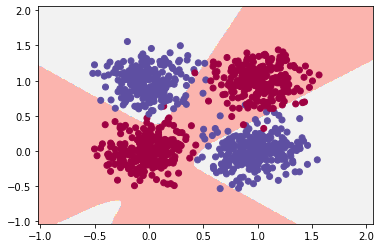

[[  8.98788518   6.2478726  -13.35752586   3.20928657]
 [ -3.90366586   7.29751015  16.84227571   5.85012212]]
[[ 0.74186822 -2.62821337  6.64225074  9.05987081]]
[[ 3.12316984 -2.08177283]
 [-2.91711219  4.3560353 ]
 [ 4.93515183 -3.65434148]
 [ 2.49023107 -1.74054596]]
[[-3.04365196  4.50791245]]
Epoch 0/100 - loss: 3062.274914 - accuracy: 0.513889 - val_loss: 415.394897 - val_acc: 0.412500
Epoch 10/100 - loss: 0.015690 - accuracy: 0.486111 - val_loss: 0.002282 - val_acc: 0.587500
Epoch 20/100 - loss: 0.000000 - accuracy: 0.486111 - val_loss: 0.000000 - val_acc: 0.587500
Epoch 30/100 - loss: 80.956170 - accuracy: 0.891667 - val_loss: 13.165666 - val_acc: 0.875000
Epoch 40/100 - loss: 200.082077 - accuracy: 0.950000 - val_loss: 56.153033 - val_acc: 0.937500
Epoch 50/100 - loss: 215.278016 - accuracy: 0.955556 - val_loss: 64.244712 - val_acc: 0.925000
Epoch 60/100 - loss: 174.534261 - accuracy: 0.941667 - val_loss: 53.376445 - val_acc: 0.925000
Epoch 70/100 - loss: 102.971844 - accurac

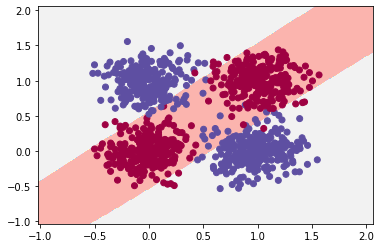

Epoch 0/100 - loss: 507.469810 - accuracy: 0.513889 - val_loss: 68.477385 - val_acc: 0.412500
Epoch 10/100 - loss: 571.422969 - accuracy: 0.513889 - val_loss: 77.550294 - val_acc: 0.412500
Epoch 20/100 - loss: 371.037776 - accuracy: 0.513889 - val_loss: 50.972228 - val_acc: 0.412500
Epoch 30/100 - loss: 327.428657 - accuracy: 0.513889 - val_loss: 45.432350 - val_acc: 0.412500
Epoch 40/100 - loss: 333.479724 - accuracy: 0.513889 - val_loss: 46.445085 - val_acc: 0.412500
Epoch 50/100 - loss: 331.783543 - accuracy: 0.518056 - val_loss: 46.441292 - val_acc: 0.412500
Epoch 60/100 - loss: 288.468195 - accuracy: 0.626389 - val_loss: 41.284220 - val_acc: 0.512500
Epoch 70/100 - loss: 196.028917 - accuracy: 0.895833 - val_loss: 29.545161 - val_acc: 0.812500
Epoch 80/100 - loss: 94.513799 - accuracy: 0.977778 - val_loss: 15.411754 - val_acc: 0.962500
Epoch 90/100 - loss: 60.005954 - accuracy: 0.979167 - val_loss: 10.511112 - val_acc: 0.962500


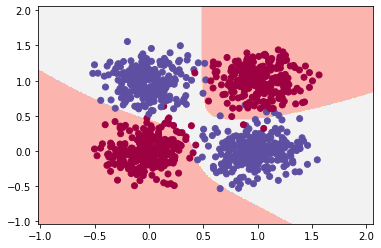

Model1 Accuracy :  0.965
Model2 Accuracy :  0.95
Model3 Accuracy :  0.975
7/7 [==============================] - 0s 2ms/step - loss: 0.0360 - accuracy: 0.9600
Keras Model Accuracy :  0.9599999785423279


'\nBased on these accuracy results, the model made here is not far off from the \nKeras model above. With the model running 100 epochs, they get similar results\naround 95-97% accuracy while the Keras model got a 96% accuracy. \n'

In [600]:
# MODEL 1: Some hyperparameters are provided, but feel free to change them.
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
nn_hidden_dim = 4 # hiden layer dimensionality
alpha = 0.01 # learning rate for gradient descent
epochs = 100 # number of iteration/epochs
# Build a model with 3 layer
myModel1 = MyNeuralNet(nn_input_dim, nn_hidden_dim, nn_output_dim, alpha);
myModel1.fit(X_train, y_train, epochs, X_val, y_val)

# Plot the decision boundary
myModel1.plot_decision_boundary(lambda x: myModel1.predict(x))
# See the weights and biases of the network
print(myModel1.W1)
print(myModel1.b1)
print(myModel1.W2)
print(myModel1.b2)


# MODEL 2 here
myModel2 = MyNeuralNet(2, 10, 2, .01);
myModel2.fit(X_train, y_train, epochs, X_val, y_val)
myModel2.plot_decision_boundary(lambda x: myModel2.predict(x))


# MODEL 3 here
myModel3 = MyNeuralNet(2, 15, 2, .001);
myModel3.fit(X_train, y_train, epochs, X_val, y_val)
myModel3.plot_decision_boundary(lambda x: myModel3.predict(x))


# COMPARISONS WITH THE STANDARD LIBRARY 
print('Model1 Accuracy : ' ,myModel1.evaluate(X_test,y_test))
print('Model2 Accuracy : ',myModel2.evaluate(X_test,y_test))
print('Model3 Accuracy : ',myModel3.evaluate(X_test,y_test))
print('Keras Model Accuracy : ',my_model.evaluate(x = X_test, y = y_test)[1])

'''
Based on these accuracy results, the model made here is not far off from the 
Keras model above. With the model running 100 epochs, they get similar results
around 95-97% accuracy while the Keras model got a 96% accuracy. 
'''


## Reflection
Write at least a paragraph answering these prompts: How did your own network perform? Is there any major differences between the implementations? Finally, reflecting on your experience implementing a learning algorithm for this assignment (Was it hard/easy/fun?, From which part did you learn the most?)!

My network performed on par with the Keras model, with the best performing model getting 1% better accuracy than Keras with 97.5%. I believe there is not much difference between the implementations of the two types of models. They have similar performance along with similar runtime to train. This assignment overall was much easier to implement in code. However, there were some things that were difficult to interpret from the Slides including the fact that we had to inverse the matrices since the shape of X was flipped. Other than that, it was as simple as reading from the slides to code. I learned the most from when I had to debug the code. I really had to understand how the back propogation was coded and had to realize the issue with the shape of X. 

---
# Get Help?
In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [lecture 10](https://docs.google.com/presentation/d/1otQfmMomWctLZKI3hHKAA4lLkbXFtagLaQov8gNh4LI/edit?usp=sharing) and [Colab Notebook 10](https://colab.research.google.com/drive/1x5biI3dP5YvvDEI0wapJcSgQNnATDzNe)
 * Talk to the TA, they are available and there to help you during office hour.
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 4:...".

Part of the codes used in this assignment is modified from Konstantinos Kitsios under the 3-Clause BSD License. Best of luck and have fun!